In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Step 1: Load your dataset using pandas
# Assuming your dataset is in CSV format
dataset_path = "data/splits/sgkf-50-25-25-size-800/images.csv"
df = pd.read_csv(dataset_path, index_col=0)

random_state = 0
# df_sample = df.sample(250, replace=False, random_state=random_state)

n_camera_samples = 20
code_samples = []
for code in df['code'].unique():
    camera_sample = df[df['code'] == code].sample(n_camera_samples, replace=False, random_state=random_state)
    code_samples.append(camera_sample)
df_sample = pd.concat(code_samples)

print('Total samples:', len(df_sample))
pd.concat([df_sample['code'].value_counts().rename('Sample'), df['code'].value_counts().rename('Total')], axis=1).T

Total samples: 600


code,235.0,1393.0,1881.0,3133.0,442.0,94.0,326.0,1538.0,278.0,1475.0,...,1606.0,1994.0,339.0,310.0,384.0,1083.0,267.0,92.0,298.0,1119.0
Sample,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
Total,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26


#### Load images as pandas dataframe

In [3]:
import pandas as pd
import cv2
import numpy as np
from sklearn.utils import Bunch

base_dir = 'data/images'
image_paths = df_sample['file_path'].map(lambda path: f'{base_dir}/{path}')
labels = df_sample['flood']

# Function to load and preprocess images
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 00 image in grayscale
    image = cv2.resize(image, (256, 256))  # Resize image to a fixed size
    return image.flatten()  # Flatten image to a 1D array

# List to store image data and file paths
images = []

# Loop through each image path
for path in image_paths:
    try:
        image = load_image(path)  # Load and preprocess image
        images.append(image)  # Append flattened image to list
        # labels.append(label)  # Append label to list
    except Exception as e:
        print(f"Error loading image '{path}': {e}")

# Convert lists to numpy arrays
images = np.array(images)

# Create DataFrame
data = pd.DataFrame(images)
data['label'] = labels.values

# Display DataFrame
display(data.head())


,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,3,7,2,37,33,36,40,34,40,37,...,66,66,65,64,61,60,60,60,60,0
1,5,8,4,38,41,44,41,43,49,43,...,20,19,22,16,15,16,24,59,115,1
2,6,9,3,28,29,36,33,32,36,35,...,28,28,28,28,28,28,28,28,28,1
3,2,5,3,22,24,34,29,25,29,27,...,38,38,37,39,39,37,36,36,36,1
4,5,7,8,128,123,134,131,136,136,138,...,56,56,57,53,53,53,51,51,51,0


In [4]:
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, LeaveOneGroupOut

test_prct = 0.20
n_splits_test = int(1.0 / test_prct)

# Stratified group KFold testing split
# sgkf = GroupKFold(n_splits=n_splits_test)
# sgkf = StratifiedGroupKFold(n_splits=n_splits_test, shuffle=True, random_state=random_state)
sgkf = LeaveOneGroupOut()
print('\nSplit Strategy:', sgkf, '\n')


Split Strategy: LeaveOneGroupOut() 



[learning_curve] Training set sizes: [ 5 11 17 23 29 34 40 46 52 58]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   55.1s finished


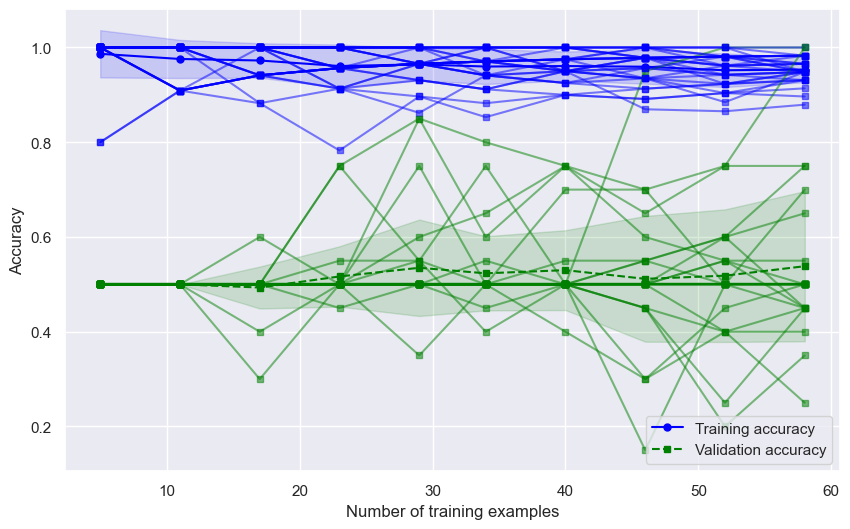

In [6]:
# Step 2: Preprocess your data and split it into features and target variable
# Assuming the last column is the target variable and rest are features
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Target variable

# Step 3: Define your machine learning model
# Assuming you're using Support Vector Machine (SVM) as your classifier
model = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto'))
# model = make_pipeline(StandardScaler(), LinearSVC())
# model = make_pipeline(StandardScaler(), SGDClassifier(loss='hinge'))

# Step 4: Use the learning_curve function to generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    train_sizes=np.linspace(0.01, 0.1, 10),  # Varying training set sizes
    cv=sgkf,  # Number of cross-validation folds
    scoring='accuracy',  # Scoring metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=True,
    shuffle=True,
    groups=df_sample['code'].values,
    random_state=random_state,
    error_score='raise',
)

# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

for i in range(len(train_scores[0])):
    plt.plot(train_sizes, train_scores[:, i], marker='s', markersize=5, alpha=0.50, color='blue')
    plt.plot(train_sizes, test_scores[:, i], marker='s', markersize=5, alpha=0.50, color='green')

plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
# plt.grid()
plt.show()

In [18]:
train_sizes, train_scores, test_scores

(array([ 5,  8, 10, 13, 16, 18, 21, 23, 26, 29]),
 array([[1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 0.875     , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.    

In [19]:
pd.DataFrame(test_scores, index=train_sizes)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
5,0.65,0.45,0.45,0.50,0.65,0.20,0.50,0.50,0.40,0.45,...,0.50,0.50,0.50,0.50,0.50,0.5,0.05,0.5,0.50,0.50
8,0.65,0.55,0.50,0.40,0.75,0.50,0.40,0.20,0.50,0.05,...,0.50,0.50,0.40,0.35,0.50,0.5,0.50,0.5,0.65,0.50
10,0.65,0.60,0.50,0.45,0.75,0.25,0.50,0.20,0.45,0.50,...,0.50,0.50,0.50,0.40,0.75,0.5,0.50,0.5,0.65,0.50
13,0.80,0.55,0.50,0.30,0.35,0.30,0.65,0.80,0.20,0.15,...,0.50,0.00,0.35,0.40,0.80,0.5,0.50,0.5,0.85,0.50
16,0.75,0.60,0.45,0.20,0.25,0.45,0.70,0.50,0.20,0.30,...,0.50,0.05,0.50,0.50,0.50,0.5,0.40,0.5,0.60,0.50
18,0.80,0.55,0.45,0.40,0.50,0.60,0.50,0.80,0.40,0.50,...,0.80,0.45,0.45,0.50,1.00,0.5,0.70,0.5,0.60,0.50
21,0.85,0.60,0.40,0.45,0.30,0.55,0.60,0.55,0.40,0.55,...,0.50,0.05,0.50,0.50,0.50,0.5,0.70,0.5,0.50,0.50
23,0.85,0.55,0.55,0.55,0.20,0.65,0.55,0.45,0.50,0.55,...,0.50,0.00,0.35,0.50,0.90,0.5,0.50,0.5,0.50,0.35
26,0.85,0.55,0.45,0.65,0.35,0.65,0.55,0.65,0.30,0.55,...,0.75,0.00,0.45,0.50,0.80,0.6,0.60,0.5,0.75,0.50
29,0.85,0.45,0.50,0.45,0.15,0.50,0.50,0.50,0.45,0.40,...,0.60,0.00,0.45,0.50,0.90,0.5,0.50,0.5,0.55,0.50
